# reduce the number of connections of mega hubs

In [1]:
import pandas as pd
from collections import defaultdict
from tqdm import tqdm
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
from copy import deepcopy

In [2]:
%matplotlib inline

In [3]:
random.seed(20190320)

## Read data

In [4]:
nodes = pd.read_csv(
    "data/hetio_nodes.tsv", sep='\t'
)

In [5]:
edges = pd.read_csv(
    "data/hetio_edges.tsv", sep='\t', low_memory=False
)

In [6]:
edges.head()

,start_id,end_id,het_etype,source_uid,target_uid
0,8568,GO:0042254,PARTICIPATES_GpBP,26311,5975
1,6201,GO:0042254,PARTICIPATES_GpBP,9449,5975
2,6223,GO:0042254,PARTICIPATES_GpBP,32586,5975
3,6202,GO:0042254,PARTICIPATES_GpBP,21669,5975
4,65003,GO:0042254,PARTICIPATES_GpBP,20653,5975


---

In [7]:
def get_adjlist(edges):
    adjlist = defaultdict(set)

    for suid, tuid in tqdm(zip(edges["source_uid"], edges["target_uid"]),
        total=len(edges)
        ):

            adjlist[suid].add(tuid)
            adjlist[tuid].add(suid)
    
    return adjlist

In [8]:
def get_neighbours(adjlist):
    return (pd
        .DataFrame(
            [(node, len(vals)) for node, vals in adjlist.items()],
            columns = ["node_uid", "num_neighbours"]
        )
        .assign(log_neighbours = lambda df: np.log10(df["num_neighbours"]))
    )

In [9]:
adj_list = get_adjlist(edges)

100%|██████████| 2249052/2249052 [00:02<00:00, 908044.87it/s]


In [10]:
neighbours = get_neighbours(adj_list)

---

In [11]:
lab_neigh = (neighbours
    .merge(
        nodes, how="inner", on="node_uid"
    )
)

In [12]:
lab_neigh.head()

,node_uid,num_neighbours,log_neighbours,node_id,name,het_type
0,0,27,1.431364,DB00795,Sulfasalazine,Compound
1,1,4,0.602060,N0000000151,Histamine H2 Receptor Antagonists,Pharmacologic Class
2,3,2,0.301030,DB04898,Ximelagatran,Compound
3,4,4,0.602060,C0278151,Facial spasm,Side Effect
4,5,8,0.903090,56136,PCDHA13,Gene


### identify top 10% of nodes by neighbours per node type

In [13]:
top10pct = (lab_neigh
    .sort_values("num_neighbours", ascending=False)
    .groupby("het_type")
    .apply(
        lambda df: df.head(len(df)//10)
    )
    .reset_index(drop=True)
)

In [14]:
top10pct.shape

(4512, 6)

In [15]:
top10pct.head()

,node_uid,num_neighbours,log_neighbours,node_id,name,het_type
0,17335,15981,4.203604,UBERON:0000955,brain,Anatomy
1,45651,15519,4.190864,UBERON:0000473,testis,Anatomy
2,31704,14274,4.154546,UBERON:0002369,adrenal gland,Anatomy
3,20636,14015,4.146593,UBERON:0000948,heart,Anatomy
4,38273,13942,4.144325,UBERON:0002048,lung,Anatomy


In [16]:
top10pct["het_type"].value_counts()

Gene                   1914
Biological Process     1138
Side Effect             570
Molecular Function      288
Pathway                 182
Compound                153
Cellular Component      139
Symptom                  41
Anatomy                  40
Pharmacologic Class      34
Disease                  13
Name: het_type, dtype: int64

Text(0,0.5,'Node semantic type')

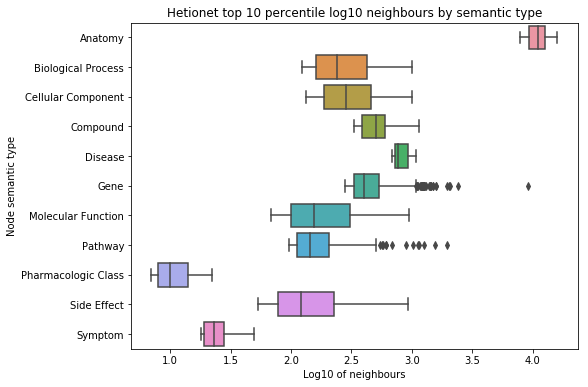

In [17]:
plt.figure(figsize=(8, 6))

ax = sns.boxplot(data=top10pct, y="het_type", x="log_neighbours")
ax.set_title("Hetionet top 10 percentile log10 neighbours by semantic type")
ax.set_xlabel("Log10 of neighbours")
ax.set_ylabel("Node semantic type")

---

## reduce size of the top 10 percentile by 30%

In [18]:
REMOVE_AMT = 0.3

removed_adj = defaultdict(set)

for node_uid, neighs in zip(
    top10pct["node_uid"], top10pct["num_neighbours"]):
    
    discard = math.floor(REMOVE_AMT * neighs)
    
    removed_adj[node_uid] = random.sample(adj_list[node_uid], discard)

### determine list of edges to remove

In [19]:
removed_pairs = []
for key, vals in removed_adj.items():
    for val in vals:
        removed_pairs.append((key, val))
        removed_pairs.append((val, key))
        
removed_pairs = set(removed_pairs)

In [20]:
len(removed_pairs)

1168178

In [21]:
edge_pairs = set(zip(edges["source_uid"], edges["target_uid"]))

In [22]:
len(edge_pairs)

2109127

In [23]:
fin_epairs = edge_pairs - removed_pairs

In [24]:
len(fin_epairs)

1523834

---

## which edges did we remove?

In [25]:
temp = (pd
    .DataFrame(
        list(removed_pairs),
        columns=["source_uid", "target_uid"]
    )
    .merge(edges, how="inner", on=["source_uid", "target_uid"])
)

In [26]:
temp.shape

(630569, 5)

In [27]:
temp.head()

,source_uid,target_uid,start_id,end_id,het_etype
0,34175,33318,DB00425,C0877609,CAUSES_CcSE
1,7875,46082,DB08865,5243,BINDS_CbG
2,34038,42733,UBERON:0001296,5818,DOWNREGULATES_AdG
3,36765,296,UBERON:0002185,9552,EXPRESSES_AeG
4,41058,33877,3718,GO:0071363,PARTICIPATES_GpBP


In [28]:
temp["het_etype"].value_counts()

PARTICIPATES_GpBP    159290
EXPRESSES_AeG        136506
REGULATES_GrG         94231
CAUSES_CcSE           42632
INTERACTS_GiG         39325
DOWNREGULATES_AdG     31567
UPREGULATES_AuG       31172
PARTICIPATES_GpMF     26155
PARTICIPATES_GpPW     21719
PARTICIPATES_GpCC     18924
DOWNREGULATES_CdG      7831
UPREGULATES_CuG        6764
COVARIES_GcG           6555
ASSOCIATES_DaG         2407
BINDS_CbG              1828
UPREGULATES_DuG        1334
DOWNREGULATES_DdG      1175
PRESENTS_DpS            412
RESEMBLES_CrC           310
LOCALIZES_DlA           262
INCLUDES_PCiC           145
RESEMBLES_DrD            25
Name: het_etype, dtype: int64

In [29]:
nodes.head()

,node_uid,node_id,name,het_type
0,0,DB00795,Sulfasalazine,Compound
1,1,N0000000151,Histamine H2 Receptor Antagonists,Pharmacologic Class
2,2,100996420,DNM1P50,Gene
3,3,DB04898,Ximelagatran,Compound
4,4,C0278151,Facial spasm,Side Effect


In [30]:
temp.head()

,source_uid,target_uid,start_id,end_id,het_etype
0,34175,33318,DB00425,C0877609,CAUSES_CcSE
1,7875,46082,DB08865,5243,BINDS_CbG
2,34038,42733,UBERON:0001296,5818,DOWNREGULATES_AdG
3,36765,296,UBERON:0002185,9552,EXPRESSES_AeG
4,41058,33877,3718,GO:0071363,PARTICIPATES_GpBP


In [55]:
res = (temp
    .merge(
        nodes[["node_uid", "het_type", "name"]], how="inner",
        left_on="source_uid", right_on="node_uid"
    )
    .drop("node_uid", axis=1)
    .rename(columns={"het_type": "source_htype",
                    "name": "source_name"})
      
    .merge(
        nodes[["node_uid", "het_type", "name"]], how="inner",
        left_on="target_uid", right_on="node_uid"
    )
    .drop("node_uid", axis=1)
    .rename(columns={
        "het_type": "target_htype",
        "name": "target_name"
    })
      
)

In [56]:
res.head()

,source_uid,target_uid,start_id,end_id,het_etype,source_htype,source_name,target_htype,target_name
0,34175,33318,DB00425,C0877609,CAUSES_CcSE,Compound,Zolpidem,Side Effect,Alertness decreased
1,34175,23915,DB00425,C0017601,CAUSES_CcSE,Compound,Zolpidem,Side Effect,Glaucoma
2,30116,23915,DB00465,C0017601,CAUSES_CcSE,Compound,Ketorolac,Side Effect,Glaucoma
3,21914,23915,DB01267,C0017601,CAUSES_CcSE,Compound,Paliperidone,Side Effect,Glaucoma
4,24248,23915,DB00712,C0017601,CAUSES_CcSE,Compound,Flurbiprofen,Side Effect,Glaucoma


In [57]:
res.shape

(630569, 9)

In [58]:
hi = (res
    .groupby(["source_htype", "target_htype"])
    .size()
    .to_frame("num_edges")
    .reset_index()
)

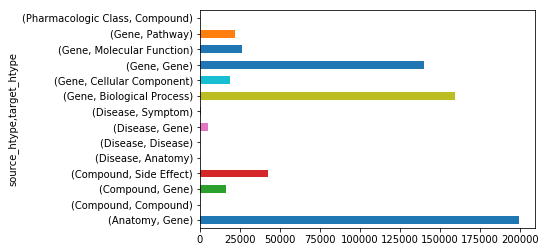

In [59]:
(res
    .groupby(["source_htype", "target_htype"])
    .size()
    .plot(kind="barh")
)
 

In [60]:
res.query("source_htype == 'Anatomy' and target_htype == 'Gene'")

,source_uid,target_uid,start_id,end_id,het_etype,source_htype,source_name,target_htype,target_name
1714,5783,39586,UBERON:0002107,1565,UPREGULATES_AuG,Anatomy,liver,Gene,CYP2D6
1715,5783,39586,UBERON:0002107,1565,EXPRESSES_AeG,Anatomy,liver,Gene,CYP2D6
1717,39662,39586,UBERON:0000992,1565,EXPRESSES_AeG,Anatomy,female gonad,Gene,CYP2D6
1718,31704,39586,UBERON:0002369,1565,UPREGULATES_AuG,Anatomy,adrenal gland,Gene,CYP2D6
1722,4038,39586,UBERON:0002368,1565,EXPRESSES_AeG,Anatomy,endocrine gland,Gene,CYP2D6
1724,30934,39586,UBERON:0000474,1565,EXPRESSES_AeG,Anatomy,female reproductive system,Gene,CYP2D6
1743,11713,39586,UBERON:0001007,1565,EXPRESSES_AeG,Anatomy,digestive system,Gene,CYP2D6
1749,20164,39586,UBERON:0001008,1565,EXPRESSES_AeG,Anatomy,renal system,Gene,CYP2D6
1752,7092,39586,UBERON:0001890,1565,EXPRESSES_AeG,Anatomy,forebrain,Gene,CYP2D6
1754,17112,39586,UBERON:0002390,1565,EXPRESSES_AeG,Anatomy,hematopoietic system,Gene,CYP2D6


In [46]:
hi

,source_htype,target_htype,num_edges
0,Anatomy,Gene,199245
1,Compound,Compound,310
2,Compound,Gene,16423
3,Compound,Side Effect,42632
4,Disease,Anatomy,262
5,Disease,Disease,25
6,Disease,Gene,4916
7,Disease,Symptom,412
8,Gene,Biological Process,159290
9,Gene,Cellular Component,18924


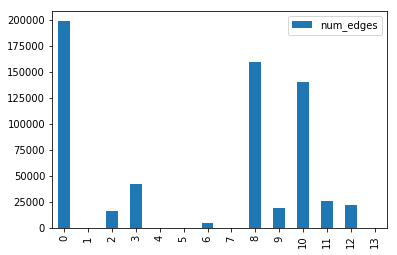

In [48]:
hi.plot(kind="bar")

In [ ]:
sns.barplot(data=hi, x="")

---

In [25]:
fedges = (pd
    .DataFrame(
        list(fin_epairs), columns=["source_uid", "target_uid"]
    )
    .merge(edges, how="left", on=["source_uid", "target_uid"])
)

In [26]:
fedges.shape

(1618483, 5)

In [27]:
fedges.head()

,source_uid,target_uid,start_id,end_id,het_etype
0,44540,36541,3726,PC7_4112,PARTICIPATES_GpPW
1,22965,25660,DB06207,C0027441,CAUSES_CcSE
2,29844,10177,UBERON:0003126,222229,EXPRESSES_AeG
3,39790,42360,1463,GO:0009101,PARTICIPATES_GpBP
4,39178,21356,UBERON:0001225,252839,UPREGULATES_AuG


In [28]:
fedges.to_csv("data/reduced_edges.tsv", sep='\t', index=False)